In [1]:
# cosmology related modules
import astropy
from astropy.cosmology import Planck18
from astropy.constants import c
from astropy import units as u
# for catalogues generation
from scipy.stats import uniform
import random as rnd
from scipy import stats
#from sklearn.neighbors import KernelDensity

#general tools
import sys
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import scipy.fftpack
from numpy.fft import *
from scipy.integrate import quad
import scipy.special
#from statistics import mean
from matplotlib import pyplot as plt 
import matplotlib.colors as colors
import math

#superrad
import os
from pathlib import Path
current = os.path.dirname(os.path.realpath('__file__'))
parent = os.path.dirname(current)
sys.path.append(parent)
from superrad.ultralight_boson import UltralightBoson
from superrad.cloud_model import CloudModel
# cosmology related modules
import astropy
from astropy.cosmology import Planck18
from astropy.constants import c
from astropy import units as u



## Scalars

In [2]:
# from SuppeRad
bc = UltralightBoson(spin=0, model="relativistic")

In [3]:
data=np.loadtxt("q3nod10.dat");

In [9]:
# Use cosmology consistent with Planck data 
cosmo = Planck18
cu = c.to('Mpc/yr').value # speed of light in Mpc per year
H0 = Planck18.H0.value # km/s/Mpc
cuk = c.to('km/s').value #km/s
# General useful quantities:
sec_hour = 3600.0 #sec in an hour
sec_year = 3.154*10**7 #sec in a year
# LISA / mission/ astro/ cosmo
tmiss = 4*sec_year #LISA mission duration 
sec_week= 604800 # in sec

In [10]:

# LISA / mission/ astro/ cosmo
tmiss = 4*sec_year #LISA mission duration 
#tint = np.linspace(0,tmiss,17) # 4 years in 16 intervals
#dtmiss=(tint[1]-tint[0])/sec_year # in yrs



# Sensitivity curve
fstar=19.09*10**(-3) #Hz
L=2.5*10**9 #in m
A=9*10**(-45)
alpha = 0.166
beta=299
kappa=611
gamma=1340
fk=0.00173


def Poms(f):
    return ((1.5*10**(-11))**2)*(1+((2*10**(-3))/f)**4)

def Pacc(f):
    return ((3*10**(-15))**2)*(1+((0.4*10**(-3))/f)**2)*(1+(f/(8*10**(-3)))**4)

def Pn(f):
    return (Poms(f)/(L**2))+2*(1+(np.cos(f/fstar)**2))*Pacc(f)/(((2*np.pi*f)**4)*L**2)

def R(f):
    return 0.3/(1+0.6*(f/fstar)**2)

def Sc(f):
    return A*f**(-7/3)*np.exp(f**alpha+beta*f*np.sin(kappa*f))*(1+np.tanh(gamma*(fk-f)))

def S_n(f):
    return Pn(f)/R(f) + Sc(f)

# SNR calculation
def t01(f,tg,finf,Df):
    return tg*(Df/(f-finf)-1)

def ϕ01(f,tg,finf,Df):
    return (finf-f)*t01(f,tg,finf,Df)*sec_hour+Df*tg*sec_hour*np.log(Df/(f-finf))

def ddϕ01(f,tg,finf,Df):
    return -((f-finf)**2)/(Df*tg*sec_hour)

def Hf1(f,tg,finf,Df,h):
    return h/(Df/(f-finf))*np.exp(1j*2*np.pi*ϕ01(f,tg,finf,Df))*np.exp(1j*np.pi/4)*np.sqrt(1/(4*ddϕ01(f,tg,finf,Df)))
# it is already devided by 2


In [82]:
def snr(M,m,a,theta,zz,tm):
    
    
    dObs =Planck18.luminosity_distance(zz).value # Mpc
    
    wf = bc.make_waveform(M, a, m, units="physical")
    
    tc=wf.cloud_growth_time()/sec_hour;  # Cloud growth time in hours in src frame
    tgw = wf.gw_time()/sec_hour*(1+zz); # timescale of GW emission in hours in det frame
    tsrc0 = 0
    tsrcf = tm/(1+zz) - tc*sec_hour # in source frame in seconds
    
    h0p,h0x,delta = wf.strain_amp(tsrc0, theta, dObs) # Strain 
    fgw0 = wf.freq_gw(tsrc0)/(1+zz) #min frequency in detector frame 
    fmin=fgw0
    fmax=wf.freq_gw(tsrcf)/(1+zz) #max frequency in detector frame 
    #phi = wf.phase_gw(tsrc)
    
    
    
    f0 = wf.freq_gw(10**8*tgw)/(1+zz) #Hz
    δf=fgw0-f0 #Hz
    fex=np.linspace(fmin,fmax,10**4)
                                 
    int1=(np.abs(Hf1(fex,tgw,f0,δf,h0p))**2 + np.abs(Hf1(fex,tgw,f0,δf,h0x))**2)/S_n(fex)
    integral = np.trapz(int1, fex)
    snr = 2*np.sqrt(integral)
    
    return snr,tgw*sec_hour/sec_year,tc*(1+zz)*sec_hour/sec_year

In [ ]:
# Mn,an,zn,thn,tmn,moptn,wt,md,nsnrd,i

In [12]:
systs=data[:,[0,1,2,3,4,-1]]

In [14]:
def mb(alpha,M):
    m=alpha*10**(-12)/(0.075*(M/10))
    return m

array([3.75, 3.75, 3.75, ..., 0.25, 0.25, 0.25])

In [16]:
#pos=systs[systs[:, 4] >= 2.5*sec_year]

I keep the unique systems

In [77]:
# Find unique rows and their indices
unique_rows, indices = np.unique(systs, axis=0, return_index=True)

In [78]:
# Sort the indices to match the original order
sorted_indices = np.sort(indices)

In [79]:
# Keep only the unique rows from the original array
sy = systs[sorted_indices]

In [83]:
sc=[]
for i in range(sy.shape[0]):
    snn,tgw,tcs=snr(sy[i,0],mb(0.3,sy[i,0]),sy[i,1],sy[i,3],sy[i,2],sy[i,4])
    sc.append([snn,tgw,tcs])

/tmp/ipykernel_139182/2634339345.py:27: RuntimeWarning: invalid value encountered in sqrt
  snr = 2*np.sqrt(integral)


In [86]:
sc=np.array(sc)

In [87]:
np.any(~np.isnan(sc[:, 0]))

False

for all the systems that appear in all realizations in this model, none of them can support a scalar boson mass that has tc<4 years. 

In [92]:
min(sc[:,2]) # the minimum that appears is 38 years...the characteristics of this system are:

38.341108042640364

In [96]:
sy[np.argmin(sc[:,2]),:]

array([5.76040000e+04, 9.50000000e-01, 1.80650000e-01, 2.25886499e+00,
       6.30800000e+07, 1.99000000e+02])

In [99]:
sy[np.argmin(sc[:,2]),-2]/sec_year

2.0

In [91]:
file_name = "scalarstimescales.dat"
# Save the array to a .dat file
np.savetxt(file_name, sc, delimiter=' ')
print(file_name, "saved")
    

scalarstimescales.dat saved


In [71]:
asnr=[]
for i in a:
    ss,sg,sc = snr(pos[2378793,0],mb(i,pos[2378793,0]),pos[2378793,1],pos[2378793,3],pos[2378793,2],pos[2378793,4])
    asnr.append(sc)

/tmp/ipykernel_139182/2634339345.py:27: RuntimeWarning: invalid value encountered in sqrt
  snr = 2*np.sqrt(integral)


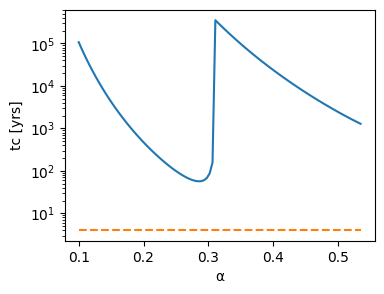

In [72]:
fig = plt.figure(figsize=(4, 3))
plt.plot(a,np.array(asnr))
plt.plot(a,4+0*a,linestyle='--')
plt.yscale('log')
plt.ylabel('tc [yrs]')
plt.xlabel('α')
plt.show()

In [73]:
asnr=[]
for i in a:
    ss,sg,sc = snr(pos[8729200,0],mb(i,pos[8729200,0]),pos[8729200,1],pos[8729200,3],pos[8729200,2],pos[8729200,4])
    asnr.append(sc)

/tmp/ipykernel_139182/2634339345.py:27: RuntimeWarning: invalid value encountered in sqrt
  snr = 2*np.sqrt(integral)


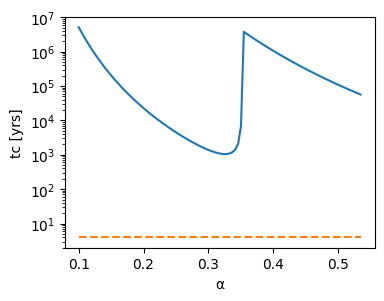

In [74]:
fig = plt.figure(figsize=(4, 3))
plt.plot(a,np.array(asnr))
plt.plot(a,4+0*a,linestyle='--')
plt.yscale('log')
plt.ylabel('tc [yrs]')
plt.xlabel('α')
plt.show()

In [64]:
snr(pos[0,0],mb(0.535,pos[0,0]),pos[0,1],pos[0,3],pos[0,2],pos[0,4])

/tmp/ipykernel_139182/2634339345.py:27: RuntimeWarning: invalid value encountered in sqrt
  snr = 2*np.sqrt(integral)


(nan, 54329475.99144776, 227080.1540620821)

In [59]:
pos[1000,0]

84090.0

In [67]:
max(pos[:,0])

8729200.0

In [68]:
min_pos = np.argmin(pos[:, 0])
max_pos = np.argmax(pos[:, 0])

In [69]:
min_pos

2378793

In [70]:
max_pos

6892958